# 05-Trip Duration Estimation



In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
import networkx as nx
import folium
import numba
import math

from itertools import pairwise
from folium.vector_layers import PolyLine, CircleMarker
from pyquadkey2 import quadkey
from pyquadkey2.quadkey import TileAnchor, QuadKey
from numba import jit

The first step in this notebook is to load the Ann Arbor road network graph using the [OSMNX](https://osmnx.readthedocs.io/en/stable/) package. Note that we are not requesting the simplifications to get better trip endpoint matches.

In [2]:
g = ox.graph_from_place('Ann Arbor, Michigan', network_type='drive', simplify=False)

Plot the city's graph.

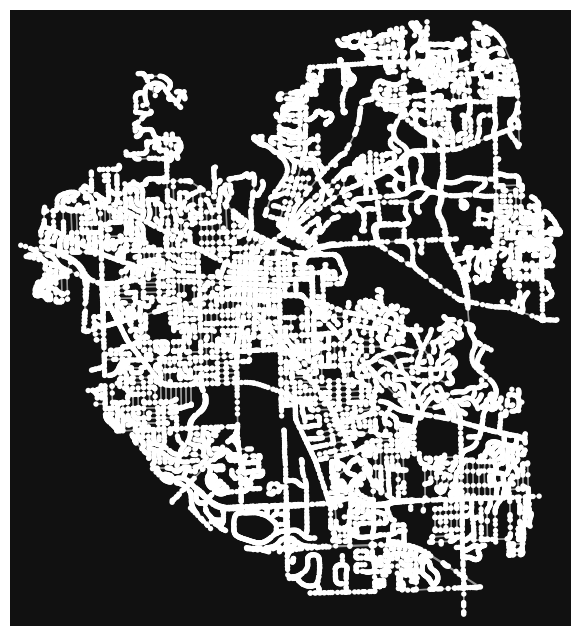

In [3]:
city = ox.plot_graph(g)

Add edge speeds to the graph. This will allow us to compare the speed inferred from the actual data to the theoretical speed.

In [4]:
g = ox.add_edge_speeds(g)

Add travel times to the edge properties.

In [5]:
g = ox.add_edge_travel_times(g)

Edge bearings are essential for querying the actual speed vectors. We will only sample speed vectors with a maximum 5 degrees deviation from the edge bearings.

In [6]:
g = ox.bearing.add_edge_bearings(g)

The code below was slightly adapted from https://max-coding.medium.com/osmnx-part-1-loading-data-from-open-street-maps-and-finding-shortest-route-between-two-points-5bb073b0a27d

In [7]:
def geocode_address(address, crs=4326):
    geocode = gpd.tools.geocode(address, provider='nominatim', 
                user_agent="QuadKey speedster").to_crs(crs)
    return geocode.iloc[0].geometry.y, geocode.iloc[0].geometry.x

Establish the start and end addresses for the route.

In [8]:
addr_ini = "122 N Thayer St, Ann Arbor, MI 48104, USA"
addr_end = "1431 Ardmoor Ave, Ann Arbor, MI 48103, USA"

Geocode the addresses into latitude and longitude coordinates.

In [9]:
loc_ini = geocode_address(addr_ini)
loc_end = geocode_address(addr_end)

Find the closest nodes in the graph.

In [10]:
node_ini = ox.distance.nearest_nodes(g, loc_ini[1], loc_ini[0])
node_end = ox.distance.nearest_nodes(g, loc_end[1], loc_end[0])

Calculate the route

In [11]:
route = nx.shortest_path(g, node_ini, node_end, weight='travel_time')

In [12]:
def fit_bounding_box(html_map, bb_list):
    if isinstance(bb_list, list):
        ll = np.array(bb_list)
    else:
        ll = bb_list
        
    min_lat, max_lat = ll[:, 0].min(), ll[:, 0].max()
    min_lon, max_lon = ll[:, 1].min(), ll[:, 1].max()
    html_map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
    return html_map

In [13]:
def swap_coordinates(coordinates):
    return [(p[1], p[0]) for p in coordinates]

In [14]:
def linestring_to_polyline(linestring):
    line = [(p[1], p[0]) for p in list(linestring.coords)]
    return PolyLine(line, weight=2, opacity=0.5)

In [15]:
def map_route(g, route):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)
    
    empty_edges = []
    bb_list = []
    
    for n in route:
        loc = g.nodes[n]
        CircleMarker((loc['y'], loc['x']), radius=2, color="red", fill="red", opacity=0.5, tooltip=n, popup=n).add_to(html_map)
        bb_list.append((loc['y'], loc['x']))
    
    for n0, n1 in pairwise(route):
        edge = g[n0][n1]
        l0 = g.nodes[n0]
        l1 = g.nodes[n1]
        line = [(l0['y'], l0['x']), (l1['y'], l1['x'])]
        
        PolyLine(line, weight=3, opacity=0.5, popup=edge[0]).add_to(html_map)
        
    return fit_bounding_box(html_map, bb_list)

In [16]:
map_route(g, route)

In [17]:
g.nodes[62496379]

{'y': 42.2723654, 'x': -83.7495413, 'street_count': 3}

In [18]:
g.nodes[62536102]

{'y': 42.272032, 'x': -83.749647, 'street_count': 3}

In [19]:
def create_map_polygon(xy, tooltip='',
                       color='#3388ff',
                       opacity=0.7,
                       fill_color='#3388ff',
                       fill_opacity=0.4, 
                       weight=1):
    points = [[x[0], x[1]] for x in xy]
    polygon = folium.vector_layers.Polygon(locations=points,
                                           tooltip=tooltip,
                                           fill=True,
                                           color=color,
                                           fill_color=fill_color,
                                           fill_opacity=fill_opacity,
                                           weight=weight,
                                           opacity=opacity)
    return polygon

In [20]:
def create_map_quadkey(qk, tooltip='',
                       color='#3388ff',
                       opacity=0.7,
                       fill_color='#3388ff',
                       fill_opacity=0.0, 
                       weight=1):
    sw = qk.to_geo(anchor=TileAnchor.ANCHOR_SW)
    ne = qk.to_geo(anchor=TileAnchor.ANCHOR_NE)
    # cc = qk.to_geo(anchor=TileAnchor.ANCHOR_CENTER)
    s, w = sw[0], sw[1]
    n, e = ne[0], ne[1]
    points = [[n, e], [s, e], [s, w], [n, w]]
    return create_map_polygon(points, tooltip=tooltip, 
                              color=color, opacity=opacity, 
                              fill_color=fill_color, fill_opacity=fill_opacity,
                              weight=weight)

In [21]:
def map_route_qk_nodes(g, route):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)
    
    empty_edges = []
    bb_list = []
    
    for n in route:
        loc = g.nodes[n]
        lat = loc['y']
        lon = loc['x']
        CircleMarker((lat, lon), radius=2, color="red", fill="red", opacity=0.5, tooltip=n, popup=n).add_to(html_map)
        bb_list.append((lat, lon))
        
        create_map_quadkey(quadkey.from_geo((lat, lon), 20)).add_to(html_map)
    
    for n0, n1 in pairwise(route):
        edge = g[n0][n1]
        l0 = g.nodes[n0]
        l1 = g.nodes[n1]
        line = [(l0['y'], l0['x']), (l1['y'], l1['x'])]
        
        PolyLine(line, weight=3, opacity=0.5, popup=edge[0]).add_to(html_map)
        
    return fit_bounding_box(html_map, bb_list)    

In [22]:
map_route_qk_nodes(g, route)

In [23]:
def decimal_part(x):
    return x - int(x)

In [24]:
decimal_part(-2.3)

-0.2999999999999998

The function below draws an anti-aliased line using [Xiaolin Wu's line drawing algorithm](https://rosettacode.org/wiki/Xiaolin_Wu%27s_line_algorithm#Python). Please note that this implementation is not a copy from the link's.

The advantage of this line drawing method is that it allows us to sample speed vectors from neighboring cells and provides a weight that we can use for each quadkey. The function outputs a list of tuples with the _x_ and _y_ coordinates as well as a weight in the \[0..1\] interval.

In [25]:
def smooth_line(x0: int, y0: int, x1: int, y1: int):
    line = []
    steep = (abs(y1 - y0) > abs(x1 - x0))
    
    if steep:
        x0, y0 = y0, x0
        x1, y1 = y1, x1
        
    if x0 > x1:
        x0, x1 = x1, x0
        y0, y1 = y1, y0
        
    dx = x1 - x0
    dy = y1 - y0
    gradient = 1.0 if dx == 0.0 else dy / dx
    
    xpx11 = x0
    xpx12 = x1
    intersect_y = y0
    
    if steep:
        for x in range(xpx11, xpx12 + 1):
            i_y = int(intersect_y)
            f_y = decimal_part(intersect_y)
            r_y = 1.0 - f_y
            
            line.append((i_y,     x, r_y))
            line.append((i_y + 1, x, f_y))
            
            intersect_y += gradient
    else:
        for x in range(xpx11, xpx12 + 1):
            i_y = int(intersect_y)
            f_y = decimal_part(intersect_y)
            r_y = 1.0 - f_y
            
            line.append((x, i_y,     r_y))
            line.append((x, i_y + 1, f_y))
            
            intersect_y += gradient
    return line   

In [26]:
smooth_line(0, 0, 20, 13)

[(0, 0, 1.0),
 (0, 1, 0),
 (1, 0, 0.35),
 (1, 1, 0.65),
 (2, 1, 0.7),
 (2, 2, 0.30000000000000004),
 (3, 1, 0.04999999999999982),
 (3, 2, 0.9500000000000002),
 (4, 2, 0.3999999999999999),
 (4, 3, 0.6000000000000001),
 (5, 3, 0.75),
 (5, 4, 0.25),
 (6, 3, 0.10000000000000009),
 (6, 4, 0.8999999999999999),
 (7, 4, 0.4500000000000002),
 (7, 5, 0.5499999999999998),
 (8, 5, 0.7999999999999998),
 (8, 6, 0.20000000000000018),
 (9, 5, 0.14999999999999947),
 (9, 6, 0.8500000000000005),
 (10, 6, 0.4999999999999991),
 (10, 7, 0.5000000000000009),
 (11, 7, 0.8499999999999988),
 (11, 8, 0.15000000000000124),
 (12, 7, 0.1999999999999984),
 (12, 8, 0.8000000000000016),
 (13, 8, 0.5499999999999989),
 (13, 9, 0.45000000000000107),
 (14, 9, 0.8999999999999986),
 (14, 10, 0.10000000000000142),
 (15, 9, 0.24999999999999822),
 (15, 10, 0.7500000000000018),
 (16, 10, 0.5999999999999979),
 (16, 11, 0.40000000000000213),
 (17, 11, 0.9499999999999975),
 (17, 12, 0.05000000000000249),
 (18, 11, 0.29999999999999

In [27]:
def bresenham_line(x0: int, y0: int, x1: int, y1: int):
    line = []
    
    dx = x1 - x0
    dy = y1 - y0
    
    if dy < 0:
        dy = -dy
        step_y = -1
    else:
        step_y = 1
    
    if dx < 0:
        dx = -dx
        step_x = -1
    else:
        step_x = 1
        
    dy = 2 * dy
    dx = 2 * dx
    
    line.append((x0, y0))
    
    if dx > dy:
        fraction = dy - (dx // 2)
        
        while x0 != x1:
            x0 += step_x
            if fraction >= 0:
                y0 += step_y
                fraction -= dx
            fraction += dy
            line.append((x0, y0))
    else:
        fraction = dx - (dy // 2)
        
        while y0 != y1:
            if fraction >= 0:
                x0 += step_x
                fraction -= dy
            y0 += step_y
            fraction += dx
            line.append((x0, y0))
    return line

In [28]:
bresenham_line(0, 0, 20, 13)

[(0, 0),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 3),
 (5, 3),
 (6, 4),
 (7, 5),
 (8, 5),
 (9, 6),
 (10, 7),
 (11, 7),
 (12, 8),
 (13, 8),
 (14, 9),
 (15, 10),
 (16, 10),
 (17, 11),
 (18, 12),
 (19, 12),
 (20, 13)]

In [29]:
@jit(nopython=True)
def bresenham_pairs(x0: int, y0: int,
                    x1: int, y1: int) -> np.ndarray:
    """Generates the diagonal coordinates

    Parameters
    ----------
    x0 : int
        Origin x value
    y0 : int
        Origin y value
    x1 : int
        Target x value
    y1 : int
        Target y value

    Returns
    -------
    np.ndarray
        Array with the coordinates
    """
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    dim = max(dx, dy)
    pairs = np.zeros((dim, 2), dtype=np.int64)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx // 2
        for i in range(dx):
            pairs[i, 0] = x
            pairs[i, 1] = y
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy // 2
        for i in range(dy):
            pairs[i, 0] = x
            pairs[i, 1] = y
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    return pairs


In [30]:
bresenham_pairs(0, 0, 10, 10)

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5],
       [6, 6],
       [7, 7],
       [8, 8],
       [9, 9]])

In [31]:
@jit(nopython=True)
def tile_to_qk(x, y, level):
    """
    Converts tile coordinates to a quadkey
    Code adapted from https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system
    :param x: Tile x coordinate
    :param y: Tile y coordinate
    :param level: Detail leve;
    :return: QuadKey
    """
    q = numba.types.uint64(0)
    for i in range(level, 0, -1):
        mask = 1 << (i - 1)

        q = q << 2
        if (x & mask) != 0:
            q += 1
        if (y & mask) != 0:
            q += 2
    return q

In [32]:
@jit(nopython=True)
def tile_to_str(x, y, level):
    """
    Converts tile coordinates to a quadkey
    Code adapted from https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system
    :param x: Tile x coordinate
    :param y: Tile y coordinate
    :param level: Detail leve;
    :return: QuadKey
    """
    q = ""
    for i in range(level, 0, -1):
        mask = 1 << (i - 1)

        c = 0
        if (x & mask) != 0:
            c += 1
        if (y & mask) != 0:
            c += 2
        q = q + str(c)
    return q

In [33]:
def get_qk_line(loc0, loc1, level):
    qk0 = quadkey.from_geo((loc0['y'], loc0['x']), level)
    qk1 = quadkey.from_geo((loc1['y'], loc1['x']), level)
    
    ((tx0, ty0), _) = qk0.to_tile()
    ((tx1, ty1), _) = qk1.to_tile()

    line = smooth_line(tx0, ty0, tx1, ty1)
    return [quadkey.from_str(tile_to_str(p[0], p[1], level)) for p in line if p[2] > 1e-3]

In [36]:
def map_route_qk(g, route, level=20):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)
    
    empty_edges = []
    bb_list = []
    
    for n in route:
        loc = g.nodes[n]
        lat = loc['y']
        lon = loc['x']
        CircleMarker((lat, lon), radius=2, color="red", fill="red", opacity=0.5, tooltip=n, popup=n).add_to(html_map)
        bb_list.append((lat, lon))
    
    for n0, n1 in pairwise(route):
        edge = g[n0][n1]
        l0 = g.nodes[n0]
        l1 = g.nodes[n1]
        line = [(l0['y'], l0['x']), (l1['y'], l1['x'])]
        
        PolyLine(line, weight=3, opacity=0.5, popup=edge[0]).add_to(html_map)
        
        for qk in get_qk_line(l0, l1, level):
            create_map_quadkey(qk, color="green").add_to(html_map)
            # print(qk.to_quadint() >> (64-2*level), edge[0]['bearing'])
            
    return fit_bounding_box(html_map, bb_list)    

In [37]:
map_route_qk(g, route)

In [ ]:
from db.api import EVedDb

In [ ]:
db = EVedDb()

In [ ]:
bearings_df = db.query_df("select speed, bearing from signal where quadkey = 217847238132")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
h = plt.hist(bearings_df["bearing"], bins=50)

In [ ]:
day_df = db.query_df("select trunc(day_num) as day, count(0) as n from signal group by trunc(day_num);")

In [ ]:
plt.plot(day_df['day'][:30], day_df['n'][:30])

In [ ]:
plt.plot(day_df['day'][31:62], day_df['n'][31:62])

In [ ]:
day_df['n'][55]

In [ ]:
sql = """
select   week_day
,        day_slot
,        count(distinct trunc(day_num)) as num_days
from     signal
group by week_day, day_slot;
"""

day_df = db.query_df(sql)

In [ ]:
day_df

In [ ]:
day_df['slot'] = day_df['week_day'] * 144 + day_df['day_slot']

In [ ]:
plt.plot(day_df['slot'], day_df['num_days'])

In [ ]:
(33+2) % 7

In [ ]:
def get_quadkey_avg_speed(qk_int, bearing, angle_delta = 5.0):
    sql = """
    select avg(speed) as avg_speed
    from   signal
    where  quadkey = ? and cos(radians(bearing - ?)) >= cos(radians(?));
    """
    return db.query_scalar(sql, [qk_int, bearing, angle_delta])

In [ ]:
def get_quadkey_speeds(qk_int, bearing, angle_delta = 5.0):
    sql = """
    select speed
    from   signal
    where  quadkey = ? and cos(radians(bearing - ?)) >= cos(radians(?));
    """
    speeds = db.query(sql, [qk_int, bearing, angle_delta])
    if speeds is None:
        return []
    elif len(speeds):
        return [v[0] for v in speeds if v is not None]
    else:
        return []

In [ ]:
speeds = get_quadkey_speeds(217847238116, 88.2)

In [ ]:
speeds.extend(get_quadkey_speeds(217847238117, 88.2))

In [ ]:
speeds.extend(get_quadkey_speeds(217847238128, 88.2))
speeds.extend(get_quadkey_speeds(217847238129, 88.2))

In [ ]:
len(speeds)

In [ ]:
sum(speeds) / len(speeds)

In [ ]:
sa = np.array(speeds)

In [ ]:
np.average(sa)

In [ ]:
np.std(sa)

In [ ]:
get_quadkey_avg_speed(217847238116, 88.2)

In [ ]:
level = 20

In [ ]:
def get_max_speed(edge):
    if 'maxspeed' in edge[0]:
        return edge[0]['maxspeed']
    else:
        return ""

In [ ]:
for n0, n1 in pairwise(route):
    edge = g[n0][n1]
    l0 = g.nodes[n0]
    l1 = g.nodes[n1]
    line = [(l0['y'], l0['x']), (l1['y'], l1['x'])]

    speed_list = []
    for qk in get_qk_line(l0, l1, level):
        qk_int = qk.to_quadint() >> (64-2*level)
        bearing = edge[0]['bearing']
        qks = get_quadkey_speeds(qk_int, bearing)
        if qks is not None and len(qks):
            speed_list.extend([s for s in qks if s is not None])
    
    if len(speed_list):
        speeds = np.array(speed_list)
        print(n0, n1, edge[0]['bearing'], edge[0]['speed_kph'], np.average(speeds), get_max_speed(edge))
